In [1]:
import os
import pandas as pd
import mne
import numpy as np
from matplotlib import pyplot as plt
import warnings
import glob
from src.preprocessing import preprocessing
from src.epoching import create_epochs
from src.feature_extraction import extract_psd_features

from src.analysys_utils import (
    build_master_event_map,
    load_epochs_by_condition,
    load_epochs_by_gender,
    plot_raw_data,
    plot_raw_psd,
    plot_events,
    plot_erp_comparison,
    plot_erp_difference_topomap
)

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level('ERROR')

In [2]:
DATA_FOLDER = "../dataset"
SURVEY_FILE = os.path.join(DATA_FOLDER, "Ankiety.xlsx")
UUID_COLUMN = 'UUID'
GENDER_COLUMN = 'Płeć'

EXAMPLE_USER = "2D663E30"
EXAMPLE_EEG_FILENAME = "EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif"
EXAMPLE_EEG_PATH = os.path.join(DATA_FOLDER, EXAMPLE_USER, EXAMPLE_EEG_FILENAME)

try:
    df_survey = pd.read_excel(SURVEY_FILE)
    print(f"Survey file loaded successfully. Number of participants: {len(df_survey)}")
    print(f"Columns: {df_survey.columns.tolist()}")
    display(df_survey.head())
except FileNotFoundError:
    print(f"ERROR: Survey file not found: {SURVEY_FILE}")
    df_survey = None
except Exception as e:
    print(f"ERROR while loading the survey file: {e}")
    df_survey = None

Survey file loaded successfully. Number of participants: 16
Columns: ['UUID', 'Płeć', 'Wiek', 'uwagi']


,UUID,Płeć,Wiek,uwagi
0,02F6BC66,M,22,NaN
1,1299BF1A,K,23,NaN
2,2D663E30,M,22,NaN
3,4C0F44CF,M,25,NaN
4,827366EC,M,22,NaN


In [3]:
try:
    raw_sample = mne.io.read_raw_fif(EXAMPLE_EEG_PATH, preload=True)
    raw_sample.apply_function(lambda x: x * 1e-6)

    print(raw_sample.info)
    print(f"\nSampling Frequency: {raw_sample.info['sfreq']} Hz")
    print(f"Number of Channels: {len(raw_sample.ch_names)}")
    print(f"Recording Duration: {raw_sample.times[-1]:.2f} s")

    print("\n--- Annotations (Events) ---")
    if raw_sample.annotations:
        print(f"Number of annotations: {len(raw_sample.annotations)}")
        print(f"Unique annotation types: {np.unique(raw_sample.annotations.description)}")
    else:
        print("No annotations found in the file.")

except FileNotFoundError:
    print(f"ERROR: Sample EEG file not found: {EXAMPLE_EEG_PATH}")
except Exception as e:
    print(f"ERROR while loading the EEG file: {e}")

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, T3, T4, T5, T6, F7, ...
 chs: 16 EEG, 3 misc, 1 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 250.0 Hz
>

Sampling Frequency: 250.0 Hz
Number of Channels: 21
Recording Duration: 290.70 s

--- Annotations (Events) ---
Number of annotations: 216
Unique annotation types: ['ParticipantResponse.NO' 'ParticipantResponse.YES'
 'PersonalDataField.BIRTH_DATE: PersonalDataType.CELEBRITY'
 'PersonalDataField.BIRTH_DATE: PersonalDataType.RANDO'
 'PersonalDataField.BIRTH_DATE: PersonalDataType.REAL'
 'PersonalDataField.HOMETOWN: PersonalDataType.CELEBRITY'
 'PersonalDataField.HOMETOWN: PersonalDataType.RANDO'
 'PersonalDataField.HOMETOWN: PersonalDataType.REAL'
 'PersonalDataField.NAME: Person

Generowanie wykresu: Raw signal EEG: EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif


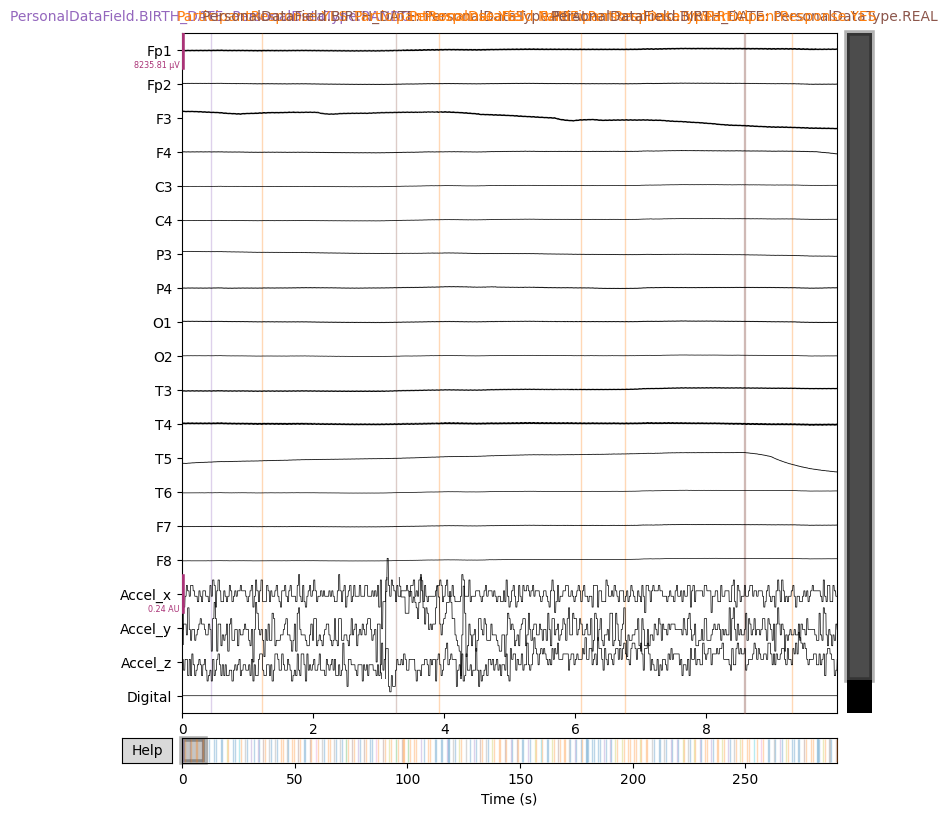

In [4]:
if 'raw_sample' in locals():
    plot_raw_data(raw_sample, title=f"Raw signal EEG: {EXAMPLE_EEG_FILENAME}")
    plt.show()

Generowanie wykresu: Gęstość Widmowa Mocy (PSD)


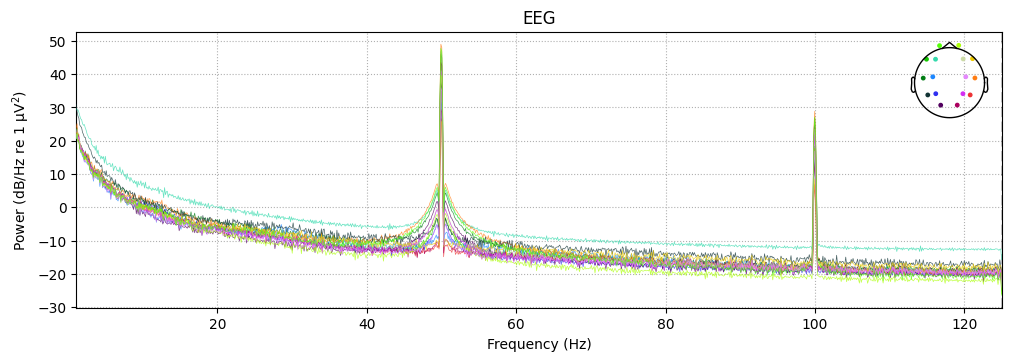

In [5]:
if 'raw_sample' in locals():
    plot_raw_psd(raw_sample)
    plt.show()

Generowanie wykresu słupkowego zdarzeń (filtr: 'PersonalDataField')...


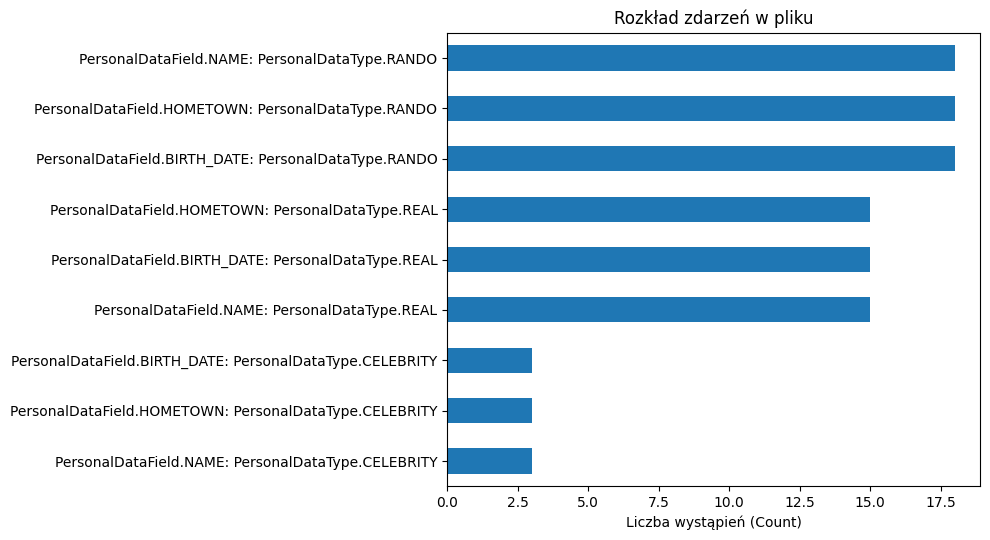

In [7]:
if 'raw_sample' in locals():
    plot_events(raw_sample)
    plt.show()

Generowanie wykresu: Signal after preprocessing


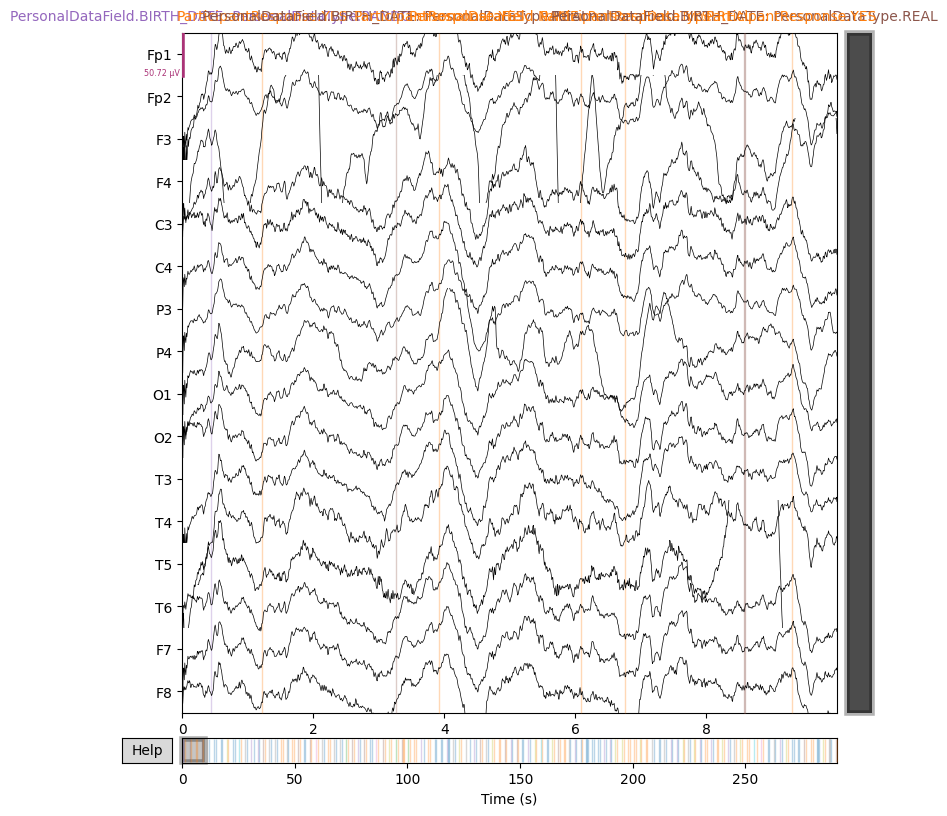

In [6]:
if 'raw_sample' in locals():
    preprocessed_sample = preprocessing(raw_sample)
    plot_raw_data(preprocessed_sample, title="Signal after preprocessing")
    plt.show()


--- Running epoching (from src.epoching) ---
Created 107 epochs.
<Epochs | 107 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~3.3 MiB, data loaded,
 np.str_('PersonalDataField.BIRTH_DATE: PersonalDataType.CELEBRITY'): 3
 np.str_('PersonalDataField.BIRTH_DATE: PersonalDataType.RANDO'): 18
 np.str_('PersonalDataField.BIRTH_DATE: PersonalDataType.REAL'): 14
 np.str_('PersonalDataField.HOMETOWN: PersonalDataType.CELEBRITY'): 3
 np.str_('PersonalDataField.HOMETOWN: PersonalDataType.RANDO'): 18
 np.str_('PersonalDataField.HOMETOWN: PersonalDataType.REAL'): 15
 np.str_('PersonalDataField.NAME: PersonalDataType.CELEBRITY'): 3
 np.str_('PersonalDataField.NAME: PersonalDataType.RANDO'): 18
 np.str_('PersonalDataField.NAME: PersonalDataType.REAL'): 15>

--- Plot 5: Sample Epochs ---


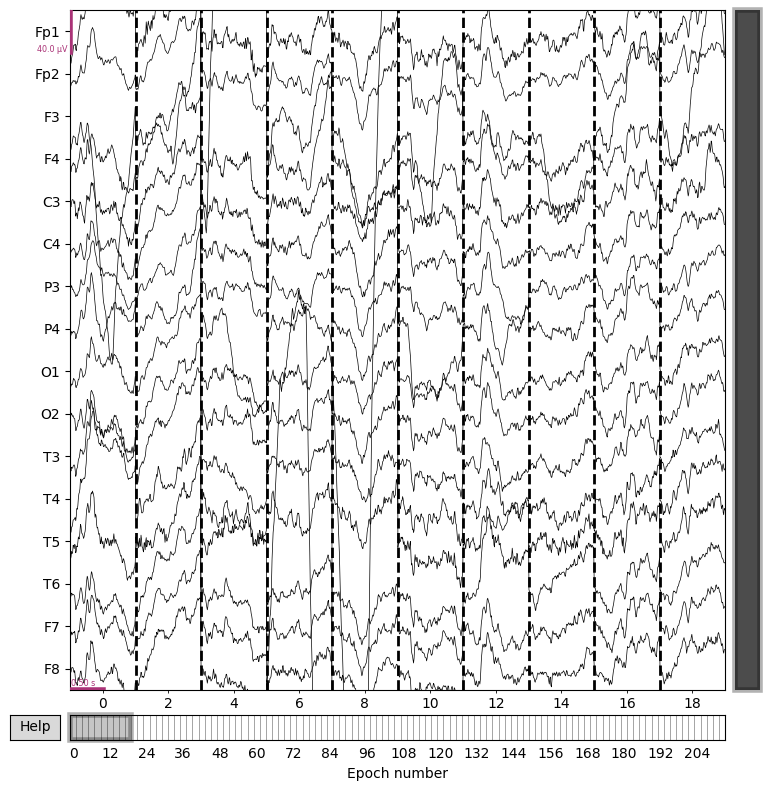

In [24]:
if 'preprocessed_sample' in locals():
    try:
        _, local_event_id = mne.events_from_annotations(preprocessed_sample)
    except ValueError:
        print("No events found in the sample file, cannot create epochs.")
        local_event_id = None

    if local_event_id:
        epochs_sample = create_epochs(preprocessed_sample, master_event_id=local_event_id)

        if epochs_sample:
            print(f"Created {len(epochs_sample)} epochs.")
            print(epochs_sample)

            epochs_sample.plot(n_epochs=10, n_channels=16, title="Sample epochs")
            plt.show()
        else:
            print("Failed to create epochs for the test file (likely no 'PersonalDataField' events).")


In [25]:
participant_dirs = [d for d in os.listdir(DATA_FOLDER) if os.path.isdir(os.path.join(DATA_FOLDER, d))
                    if "popsute" not in d.lower() and "stare" not in d.lower()]
print(f"Found {len(participant_dirs)} participant folders.")

master_event_id = build_master_event_map(DATA_FOLDER, participant_dirs)

honest_list, deceitful_list = load_epochs_by_condition(DATA_FOLDER, participant_dirs, master_event_id)

if honest_list and deceitful_list:
    all_honest_epochs = mne.concatenate_epochs(honest_list)
    all_deceitful_epochs = mne.concatenate_epochs(deceitful_list)
    print(f"\nMerged epochs: {len(all_honest_epochs)} honest, {len(all_deceitful_epochs)} deceitful.")

    evoked_honest = all_honest_epochs.average()
    evoked_deceitful = all_deceitful_epochs.average()

    evokeds_dict_all = {
        'Honest': evoked_honest,
        'Deceitful': evoked_deceitful
    }

    topo_times = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

else:
    print("Not enough data loaded for ERP analysis.")


Found 15 participant folders.
--- Building master event_id map ---
Master map created with 15 unique events.

--- Processing data for all participants ---
--- Processing participant: 02F6BC66 ---
--- Processing participant: 1299BF1A ---
--- Processing participant: 2D663E30 ---
--- Processing participant: 4C0F44CF ---
--- Processing participant: 827366EC ---
--- Processing participant: 8DB745E3 ---
--- Processing participant: A3627947 ---
--- Processing participant: a59d58f4 ---
--- Processing participant: ASD6DSA7 ---
--- Processing participant: BNFH348D ---
--- Processing participant: DAF24E45 ---
--- Processing participant: E52DEA2D ---
--- Processing participant: ff0dc21c ---
--- Processing participant: HFDY7643 ---
--- Processing participant: SDF673HF ---

Merged epochs: 3223 honest, 3240 deceitful.


Generating difference topomap plot...


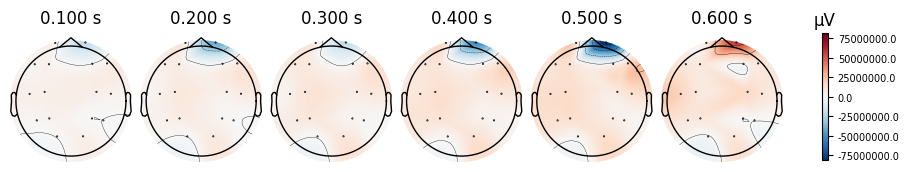

In [10]:
if 'evoked_honest' in locals() and 'evoked_deceitful' in locals():
    plot_erp_difference_topomap(evoked_honest, evoked_deceitful, times=topo_times)
    plt.show()

In [26]:
if df_survey is not None:
    male_honest_list, male_deceitful_list, female_honest_list, female_deceitful_list = load_epochs_by_gender(
        DATA_FOLDER,
        participant_dirs,
        master_event_id,
        SURVEY_FILE,
        UUID_COLUMN,
        GENDER_COLUMN
    )

    if male_honest_list and male_deceitful_list:
        evoked_male_honest = mne.concatenate_epochs(male_honest_list).average()
        evoked_male_deceitful = mne.concatenate_epochs(male_deceitful_list).average()
        evokeds_dict_male = {
            'Honest (Male)': evoked_male_honest,
            'Deceitful (Male)': evoked_male_deceitful
        }
        print("Prepared ERP data for males.")
    else:
        print("Not enough data for males.")

    if female_honest_list and female_deceitful_list:
        evoked_female_honest = mne.concatenate_epochs(female_honest_list).average()
        evoked_female_deceitful = mne.concatenate_epochs(female_deceitful_list).average()
        evokeds_dict_female = {
            'Honest (Female)': evoked_female_honest,
            'Deceitful (Female)': evoked_female_deceitful
        }
        print("Prepared ERP data for females.")
    else:
        print("Not enough data for females.")
else:
    print("Survey file not loaded, skipping gender-based analysis.")


Found 7 male and 9 female participants in survey

--- Processing data with gender segregation ---
Prepared ERP data for males.
Prepared ERP data for females.


Generating plot: ERP: honest vs deceitful male


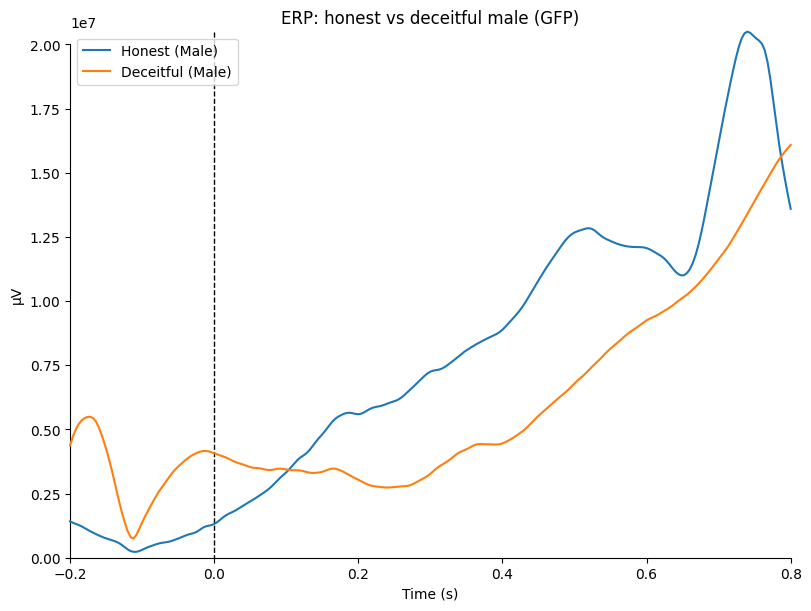

In [29]:
if 'evokeds_dict_male' in locals():
    plot_erp_comparison(evokeds_dict_male, title="ERP: honest vs deceitful male")
    plt.show()

Generating plot: ERP: honest vs deceitful female


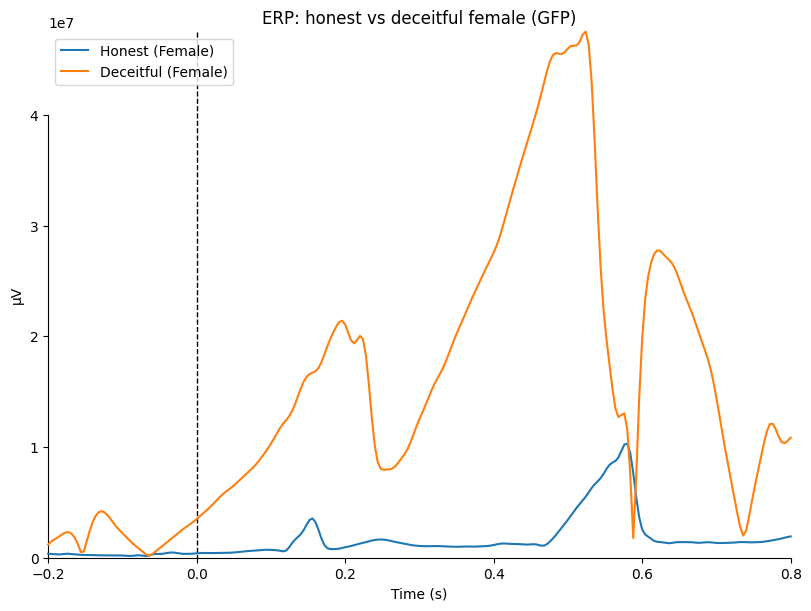

In [30]:
if 'evokeds_dict_female' in locals():
    plot_erp_comparison(evokeds_dict_female, title="ERP: honest vs deceitful female")
    plt.show()

Generating difference topomap plot...


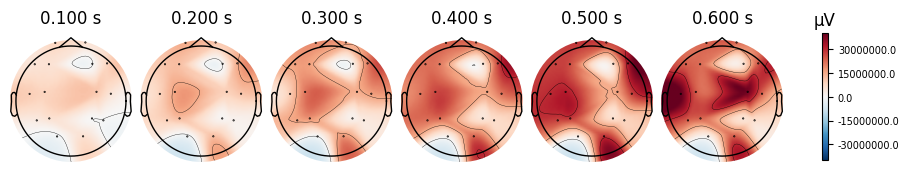

In [14]:
if 'evoked_male_honest' in locals() and 'evoked_male_deceitful' in locals():
    plot_erp_difference_topomap(evoked_male_honest, evoked_male_deceitful, times=topo_times)
    plt.show()

Generating difference topomap plot...


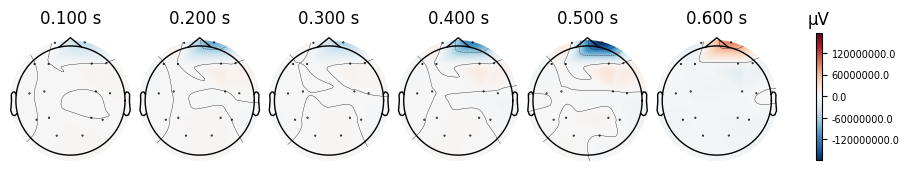

In [15]:
if 'evoked_female_honest' in locals() and 'evoked_female_deceitful' in locals():
    plot_erp_difference_topomap(evoked_female_honest, evoked_female_deceitful, times=topo_times)
    plt.show()

In [31]:
all_X = []
all_y = []

for participant_folder_name in participant_dirs:
    participant_path = os.path.join(DATA_FOLDER, participant_folder_name)
    honest_files = glob.glob(os.path.join(participant_path, "*HONEST*raw.fif"))
    deceitful_files = glob.glob(os.path.join(participant_path, "*DECEITFUL*raw.fif"))

    try:
        for h_file in honest_files:
            raw_honest = mne.io.read_raw_fif(h_file, preload=True)
            raw_honest.apply_function(lambda x: x*1e-6)
            prep_honest = preprocessing(raw_honest)
            epochs_h = create_epochs(prep_honest, master_event_id=master_event_id)
            if epochs_h and len(epochs_h) > 0:
                X_h, _ = extract_psd_features(epochs_h)
                all_X.append(X_h)
                all_y.append(np.zeros(X_h.shape[0]))  # 0 = Honest

        for d_file in deceitful_files:
            raw_deceitful = mne.io.read_raw_fif(d_file, preload=True)
            raw_deceitful.apply_function(lambda x: x*1e-6)
            prep_deceitful = preprocessing(raw_deceitful)
            epochs_d = create_epochs(prep_deceitful, master_event_id=master_event_id)
            if epochs_d and len(epochs_d) > 0:
                X_d, _ = extract_psd_features(epochs_d)
                all_X.append(X_d)
                all_y.append(np.ones(X_d.shape[0]))  # 1 = Deceitful

    except Exception as e:
        print(f"Error while processing {participant_folder_name}: {e}")

if not all_X:
    print("CRITICAL ERROR: No data loaded for the model.")
else:
    X_final = np.concatenate(all_X, axis=0)
    y_final = np.concatenate(all_y, axis=0)
    print(f"\nFinal X shape: {X_final.shape}, Final y shape: {y_final.shape}")

PSD Feature matrix X created with shape: (109, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (111, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (107, 48)
PSD Feature matrix X created with shape: (108, 48)
PSD Feature matrix X created with shape: (114, 48)
PSD Feature matrix X created wi


--- Classification Report (Cross-Validation) ---
               precision    recall  f1-score   support

   Honest (0)       0.70      0.71      0.70      3223
Deceitful (1)       0.71      0.70      0.70      3240

     accuracy                           0.70      6463
    macro avg       0.70      0.70      0.70      6463
 weighted avg       0.70      0.70      0.70      6463


--- Plot 12: Confusion Matrix (Cross-Validation) ---


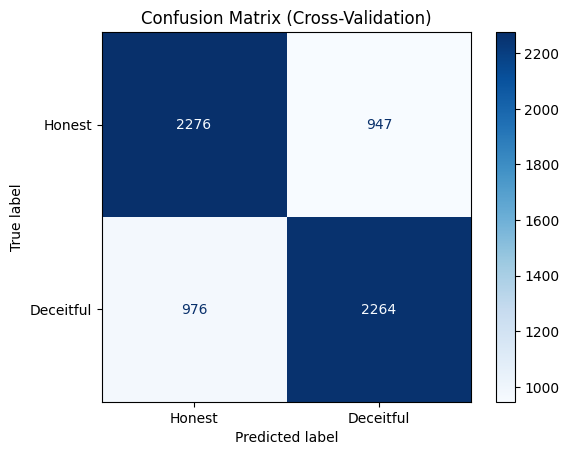

In [33]:
if 'X_final' in locals():
    model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_leaf=1,
            random_state=42,
            class_weight='balanced'
        )
    )

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred_cv = cross_val_predict(model, X_final, y_final, cv=cv_strategy, n_jobs=-1)

    print("\n--- Classification Report (Cross-Validation) ---")
    print(classification_report(y_final, y_pred_cv, target_names=['Honest (0)', 'Deceitful (1)']))

    print("\n--- Plot 12: Confusion Matrix (Cross-Validation) ---")
    cm = confusion_matrix(y_final, y_pred_cv)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Honest', 'Deceitful'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Cross-Validation)")
    plt.show()
else:
    print("The model analysis was not executed because the data was not loaded.")
